In [13]:
import torch
import torch.nn as nn
from IPython.display import Image

"""
LSTM的输入分析：
1. NLP中的输入，一个句子经过embedding是：
[[0.1, 0.2, 0.3], [0.55, 0.44, 0.44]]
多个句子是:
[
[[0.1, 0.2, 0.3], [0.55, 0.44, 0.44]], 
[[0.1, 0.2, 0.3], [0.55, 0.44, 0.44]]
]
data.shape = [batch_size, sequence_length, vocab_dim]还是[sequence_length, batch_size, vocab_dim]
2是sample数
2是每个句子的长度
3是每个单词的embedding维度

2. 其他应用的输入。
多个timestep的feature观察
[[x=0.3, y=0.4], [x=0.1, y=0.2]...
多个sample也是类似的。

所以1和2在形式上这么理解。
"""
print("start to run")

start to run


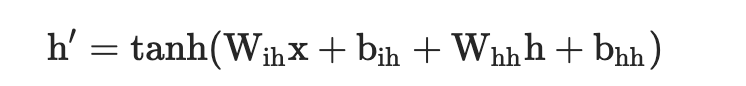

In [14]:
"""
RNN_cell是一个单元，每个时间延展需要自己来控制，虽然麻烦，但是更加灵活。
另外，这个RNN_cell跟下图不一样，他只有一个输出，hidden state，没有output。
在pytorch中，好像没有类似下图这样的实现。
"""
Image(filename='images/RNN_cell.png', width=300)

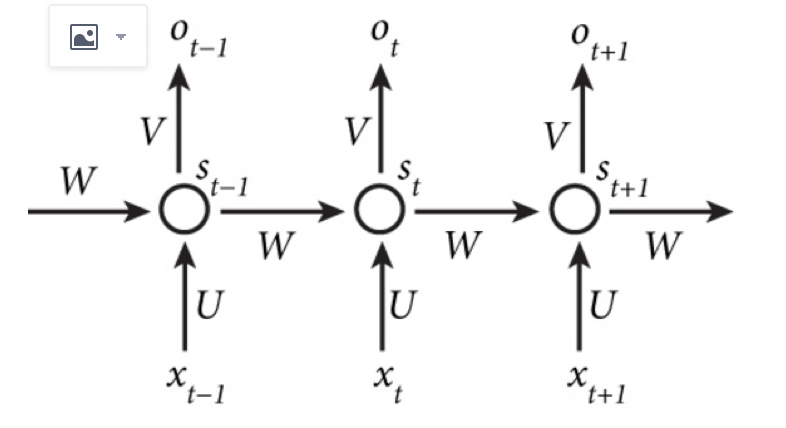

In [15]:
Image(filename='images/RNN_theory.png', width=300)

In [16]:
"""
rnn = nn.RNNCell(10, 20) - 先构造结构
hx = rnn(input[i], hx) - 真正的计算

初始化
nn.RNNCell
input_size: feature个数
hidden_size: hidden的feature个数

输入
input - (batch, input_size): 多组sample一起，input_size是feature个数
hidden -(batch, hidden_size): hidden的初始值。就是上图的S0。

输出
返回值h_t是这个时刻运行之后记忆单元的Tensor，也就是下一时刻(如果有)的单元输入，
所以它和h_{t-1}的shape是一样的，即(batch, hidden_len)。
显然，使用nn.RNNCell没法像nn.RNN那样直接求得网络的输出out，
如果需要，可以将最后一层每个时刻该单元的输出组合起来。
这里感觉是hidden state当output用啊
"""

input = torch.randn(2, 3, 10)
print("input")
print(input)
rnn = nn.RNNCell(10, 20)
hx = torch.randn(3, 20)
output = []
for i in range(2):
    hx = rnn(input[i], hx)
    output.append(hx)
print("output")
print(output)

input
tensor([[[-2.1990,  1.4228, -1.0150, -0.7758, -1.1754, -2.6297, -0.0490,
          -0.4186, -1.3889,  0.7066],
         [-0.2689, -1.3048, -1.1868,  0.1714,  0.5269,  0.0301, -0.8478,
          -0.5571, -0.4169,  0.3028],
         [-1.2338, -0.8834,  0.0134, -0.2680, -1.0439,  0.3263,  0.2878,
          -0.9998, -1.2072,  1.0081]],

        [[ 0.6033, -0.1540, -0.0768, -0.1809,  0.2898,  1.2568,  0.9425,
          -0.2382,  1.2992,  1.2986],
         [ 0.6340, -0.1688, -0.2690, -0.9214,  0.4174, -1.0486, -1.1092,
           0.5799, -0.2174,  1.7867],
         [ 0.9589, -0.3226, -0.1290, -0.2150, -0.9881, -1.6950,  0.3639,
          -0.5370,  1.3556, -0.8038]]])
output
[tensor([[-0.6046,  0.2811, -0.6160,  0.3802, -0.0062,  0.3367, -0.8284, -0.0116,
          0.0625,  0.1618, -0.3837, -0.5189,  0.6559, -0.3546, -0.2368, -0.7418,
          0.1600, -0.6292,  0.8944,  0.1417],
        [-0.2456, -0.3894, -0.2187, -0.1418,  0.3455,  0.0238, -0.2808,  0.2849,
         -0.4330, -0.0654, 

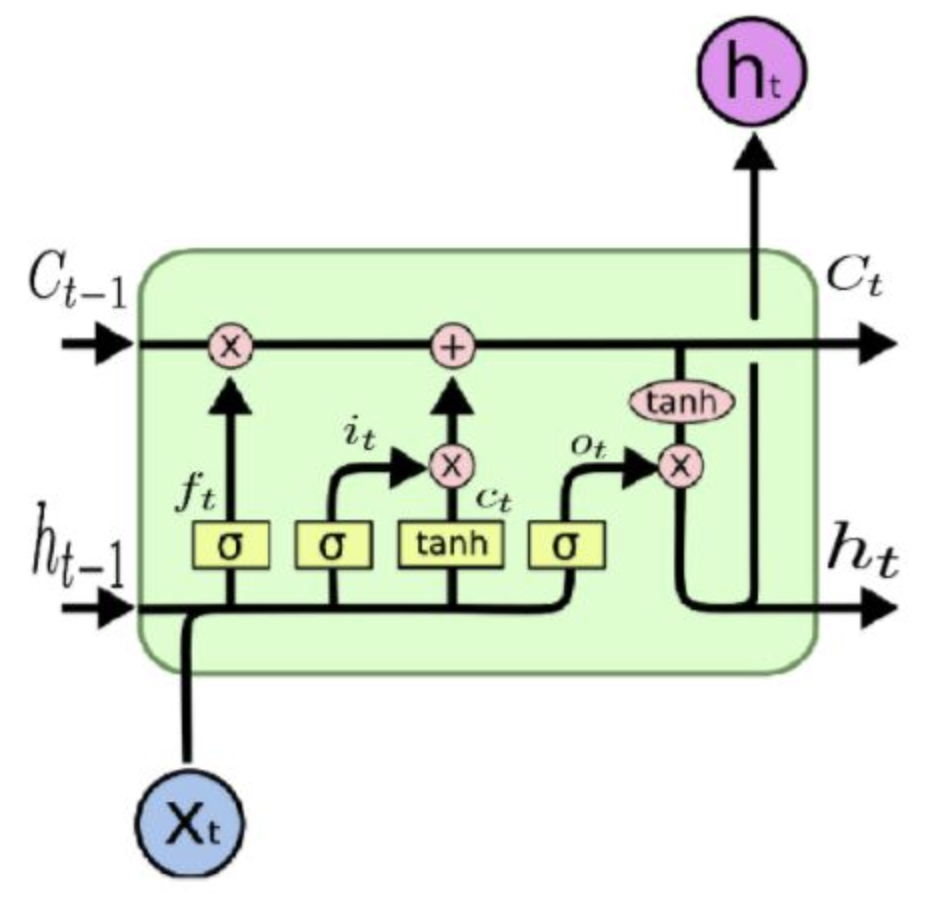

In [17]:
Image(filename='images/LSTM_cell.png', width=300)

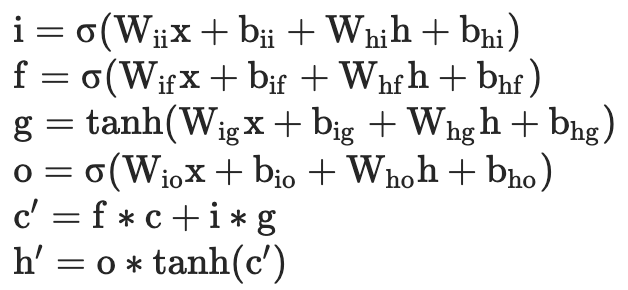

In [18]:
Image(filename='images/LSTM_formula.png', width=400)
# 这里的o称为output gate，但是实际上跟RNN_theory的output不是一个东西。

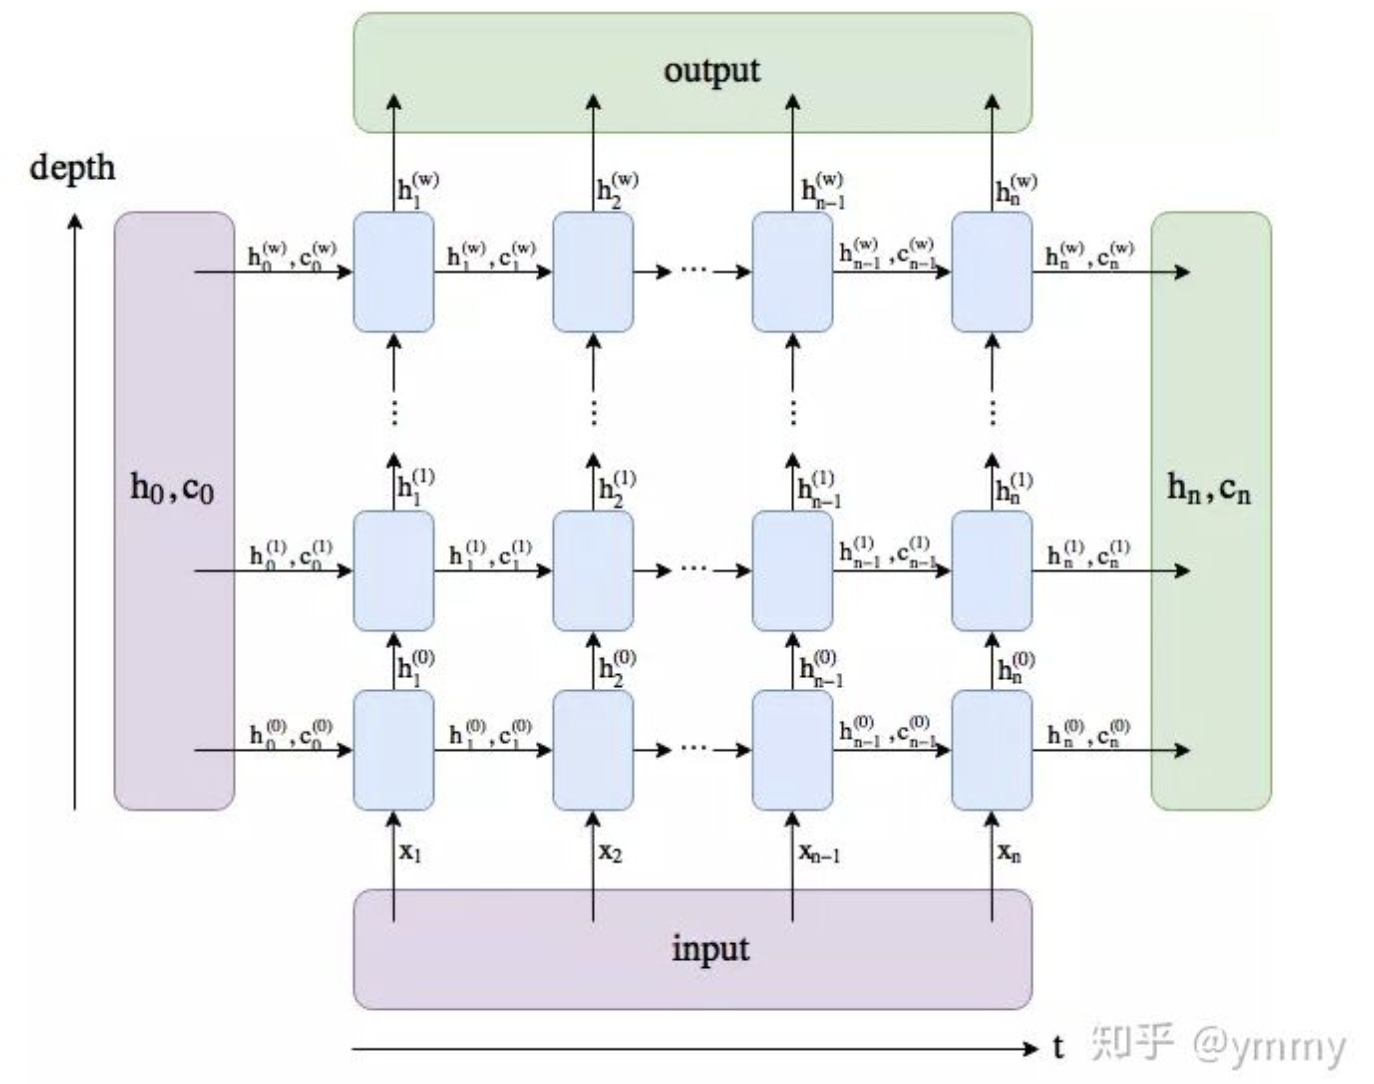

In [19]:
# 堆叠LSTM cell的多层LSTM网络。每个蓝色的就是一个LSTM cell。
"""
1. 多个cell权重共享吗？
2. x1, xn代表的是什么？
是t=1时的多个feature？所以input展示的只是t=1时刻的所有feature
还是x1代表t=1的所有输入，x2代表t=2...
从后面的解释来看，是后者。
"""
Image(filename='images/multilayer_LSTM.png', width=400)


In [20]:
"""
pytorch的LSTM cell和RNN cell的区别是：
LSTM cell的历史输入有两个:
hidden state和cell state，其中ht其实也是有些理论中的output。

初始化
nn.LSTM
input_size: feature个数
hidden_size: hidden的feature个数
number_layer: 几层堆叠

输入
input - (seq_len, batch, input_size): 多组sample一起，input_size是feature个数, 
seq_len是多个时间的value
h_0 - (num_layers*num_directions, batch, hidden_size): hidden的初始值。就是上图的h0。
注意上图默认num_directions=1。num_directions=2其实类似。
c_0 - (num_layers*num_directions, batch, hidden_size): 与上面的类似。

输出
output - (seq_len, batch, num_directions * hidden_size)
h_n - (num_layers*num_directions, batch, hidden_size): 与输入类似。
c_n - (num_layers*num_directions, batch, hidden_size): 与输入类似。
output comprises all the hidden states in the last layer ("last" depth-wise, not time-wise). 
(h_n, c_n) comprises the hidden states after the last timestep, t = n, 
so you could potentially feed them into another LSTM.
联系上图来看，output是将所有的最上面一层的hidden state合到了一起。
(h_n, c_n)在最后一个时间戳的cell_state, hidden state合到了一起。
所以实际上没有一个办法获得除了最后一个time step的所有hidden state。
"""
rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [21]:
"""
所以从pytorch的实现来看，实际上没有什么output。LTSM的output不是那个意思。
"""

'\n所以从pytorch的实现来看，实际上没有什么output。LTSM的output不是那个意思。\n'